## Missing Fingers

In [1]:
import warnings
from typing import List
import tqdm
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import probability_on_trial as pot
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns

## Core model

This is the model that given **precise** values of the parameters, estimates the posterior for two cases: (i) we know the person is from Sweden, (ii) we also know that they were in ISIS.

In [2]:
pyro.set_rng_seed(42)


pr_identity =   1/50   # high prior at this point, given other circumstantial information (tip from a woman, travel pattern, etc)
rmp_fingers_sweden = 2 / 20000 # RMP for Sweden
pr_fingers_match_if_isis = 2 / 2000 # RMP for ISIS memebers; for now a precise number 

def swedish_fingers_guilt_precise_core(
    pr_identity: float = pr_identity, 
    rmp_fingers_sweden: float =rmp_fingers_sweden,  
    pr_fingers_match_if_isis: float = pr_fingers_match_if_isis,  
    num_particles=3e6,  
):

    with pyro.plate("particles", size=num_particles):

        
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        fingers_match_sweden = pyro.sample(
            "fingers_match_sweden",
            # if guilty then 1
            # if not guilty then sample with probability rmp
            dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)),
        )

        fingers_match_isis =   pyro.sample("fingers_match_isis",
            dist.Bernoulli(
                guilty * 1
                + (1 - guilty) * pr_fingers_match_if_isis
                                ),
        )
        

    # Evidence mask 1: fingers match
    evidence_mask_fingers_sweden = (fingers_match_sweden).bool()
    guilty_masked_fingers_sweden = pyro.deterministic(
        "guilty_masked_fingers_sweden",
        torch.where(evidence_mask_fingers_sweden, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_sweden = pyro.deterministic(
        "posterior_guilty_fingers_sweden", torch.nanmean(guilty_masked_fingers_sweden, axis=0)
    )

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis).bool()
    

    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis"        ,
        torch.nanmean(guilty_masked_fingers_isis, axis=0),
    )

    return {
        "posterior_guilty_fingers_sweden": posterior_guilty_fingers_sweden,
        "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis,
    }


pyro.set_rng_seed(422323)
outcome = swedish_fingers_guilt_precise_core()
print(outcome)

posterior_sweden = outcome["posterior_guilty_fingers_sweden"]
posterior_isis = outcome["posterior_guilty_fingers_isis"]

{'posterior_guilty_fingers_sweden': tensor(0.9949), 'posterior_guilty_fingers_isis': tensor(0.9540)}


## Grid inspection

Here we look at a range of options and inspect the impact they'd have on the posteriors.

In [3]:

prior_options = torch.linspace(0.001,0.1, 30)
isis_options = torch.linspace(1, 20, 30) * 2/20000

prior_grid, isis_grid = torch.meshgrid(prior_options, isis_options)

prior_flat = prior_grid.flatten()
isis_flat = isis_grid.flatten()

sweden_list = []
isis_list = []

iter = tqdm.notebook.tqdm(range(len(isis_flat)), desc="Combination")
for i in iter:
    pr = prior_flat[i]
    isis = isis_flat[i]

    outcome =  swedish_fingers_guilt_precise_core(pr_identity=pr,
                                             pr_fingers_match_if_isis=isis)
    sweden_list.append(outcome["posterior_guilty_fingers_sweden"])
    isis_list.append(outcome["posterior_guilty_fingers_isis"])


/home/rafal/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Combination:   0%|          | 0/900 [00:00<?, ?it/s]

bone


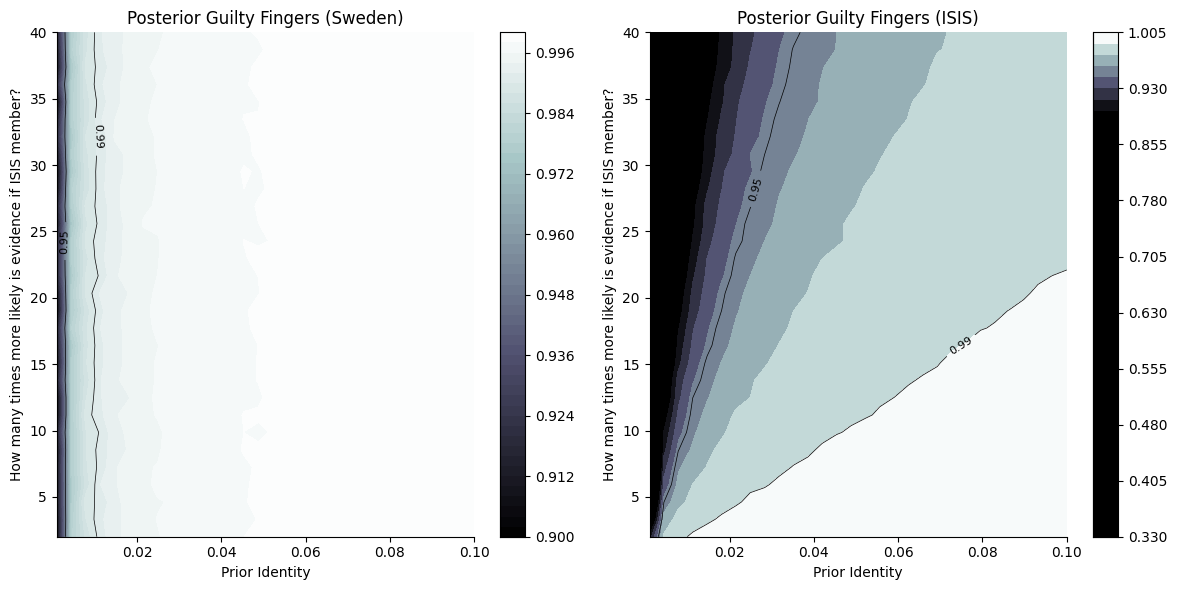

In [4]:

Norm = plt.Normalize(vmin=0.9, vmax=1)

grid_shape = (len(prior_options), len(isis_options))
sweden_array = np.clip(np.array(sweden_list).reshape(grid_shape),a_min = 0, a_max = 1)
isis_array = np.clip(np.array(isis_list).reshape(grid_shape), a_min = 0, a_max = 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colormaps = plt.colormaps()

cmap = colormaps[40]

print(cmap)

c1 = ax[0].contourf(prior_options.numpy(), isis_options.numpy(), sweden_array.T, levels=50,
                    cmap=cmap, norm = Norm)
clines1 = ax[0].contour(prior_options.numpy(), isis_options.numpy(),
                        sweden_array.T, levels=[0.95, .99], colors='k', linewidths=0.5)
ax[0].clabel(clines1, inline=True, fontsize=8, fmt="%.2f")
ax[0].set_title("Posterior Guilty Fingers (Sweden)")
ax[0].set_xlabel("Prior Identity")
formatter = ticker.FuncFormatter(lambda x, _: f"{x * 20000:,.0f}")
ax[0].yaxis.set_major_formatter(formatter)
ax[0].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c1, ax=ax[0])

# Plot for ISIS
c2 = ax[1].contourf(prior_options.numpy(), isis_options.numpy(), isis_array.T, levels=50, 
                    cmap=cmap, norm = Norm )
clines2 = ax[1].contour(prior_options.numpy(), isis_options.numpy(),
                        isis_array.T, levels=[0.95, 0.99], colors='k', linewidths=0.5)
ax[1].clabel(clines2, inline=True, fontsize=8, fmt="%.2f")
ax[1].set_title("Posterior Guilty Fingers (ISIS)")
ax[1].set_xlabel("Prior Identity")
ax[1].yaxis.set_major_formatter(formatter)
ax[1].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c2, ax=ax[1])


sns.despine()
plt.tight_layout()
plt.show()

## Evidence weights for a single precise case

We take each probability for an event to correspond to a distribution over two states; as such, we can calculate its entropy just like with any other distribution.

In [5]:
# putting probabilities in the form of probabilities for all (two) options explicitly
# wrap in a function for later use

def weights_by_case(posterior_sweden, posterior_isis, pr_identity):

    posterior_guilt_sweden = torch.tensor(
        [
            1 - posterior_sweden,
            posterior_sweden,
        ]
    )

    posterior_guilt_isis = torch.tensor(
        [
            1 - posterior_isis,
            posterior_isis
        ]
    )

    prior_guilt = torch.tensor([1 - pr_identity, pr_identity])

    
    return (pot.weight(posterior_guilt_sweden, prior_guilt),  pot.weight(posterior_guilt_isis, prior_guilt))

weights_by_case(posterior_sweden, posterior_isis, pr_identity)

(tensor(0.9224), tensor(0.5927))

## Setting Bayesian priors on parameters

/tmp/ipykernel_22297/2328877251.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


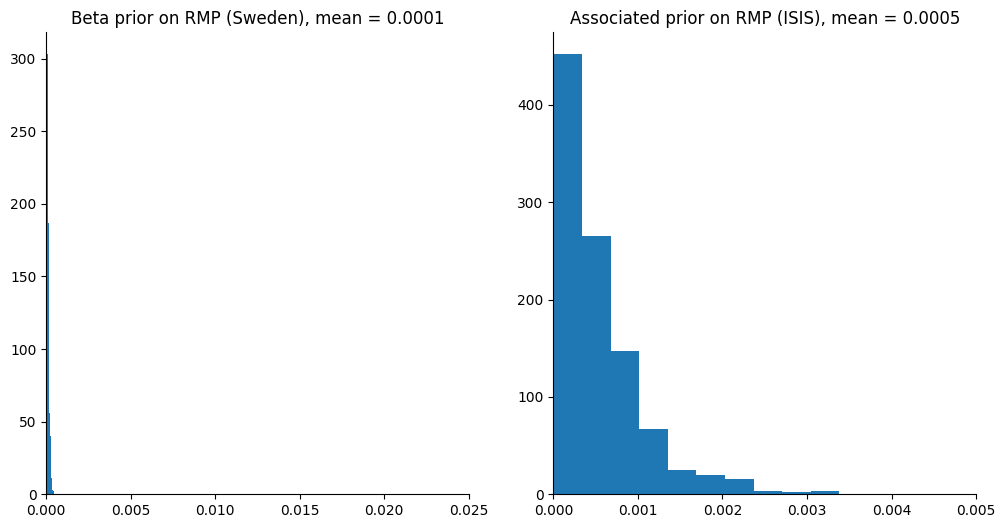

In [6]:
# for Sweden, the observed cases dicate the Beta distribution parameters,
#  2 out of 20000 observations

with pyro.plate("samples", 1000):
    probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))


# for isis, suppose for now we guess uniformly the RMP is between 1 and 10 times higher

with pyro.plate("multipliers", 1000):
    multiplier = pyro.sample("probs_isis", dist.Uniform(1, 10))
    probs_isis = (probs_sweden * multiplier).clamp(0, 1)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(probs_sweden)
ax[0].set_title(f"Beta prior on RMP (Sweden), mean = {probs_sweden.mean():.4f}")
ax[0].set_xlim(0,.025)



ax[1].hist(probs_isis)
ax[1].set_title(f"Associated prior on RMP (ISIS), mean = {probs_isis.mean():.4f}")
ax[1].set_xlim(0,.005)


sns.despine()
fig.show()

## Getting posteriors by composing Bayesian priors with the precise model


Now we put the priors together with the precise core. We sample from priors, pass to the precise model, collect the propagated posteriors.

In [9]:
bayesian_samples = 2000

def bayesian_missing_fingers():
    outcomes = []

    with pyro.plate("bayesia_samples", bayesian_samples):
        probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))
        multiplier = pyro.sample("probs_isis", dist.Uniform(1, 100))
        probs_isis = (probs_sweden * multiplier).clamp(0, 1)

        outcomes = swedish_fingers_guilt_precise_core(rmp_fingers_sweden= probs_sweden, 
                                                      pr_fingers_match_if_isis=probs_isis,
                                                      num_particles=3e5)


        return outcomes

outcomes = bayesian_missing_fingers()

## Compute weights using the posteriors

In [13]:
sweden_weights = []
isis_weights = []
iter = tqdm.notebook.tqdm(range(bayesian_samples), desc="Bayesian sample")
for i in iter:
    sweden_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_sweden'][i],  outcomes['posterior_guilty_fingers_sweden'][i]])
    isis_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_isis'][i], outcomes['posterior_guilty_fingers_isis'][i]])

    sweden_weights.append(pot.weight(sweden_distro, pr_identity))
    isis_weights.append(pot.weight(isis_distro, pr_identity))

outcomes['sweden_weights'] = sweden_weights 
outcomes['isis_weights'] = isis_weights


Bayesian sample:   0%|          | 0/2000 [00:00<?, ?it/s]

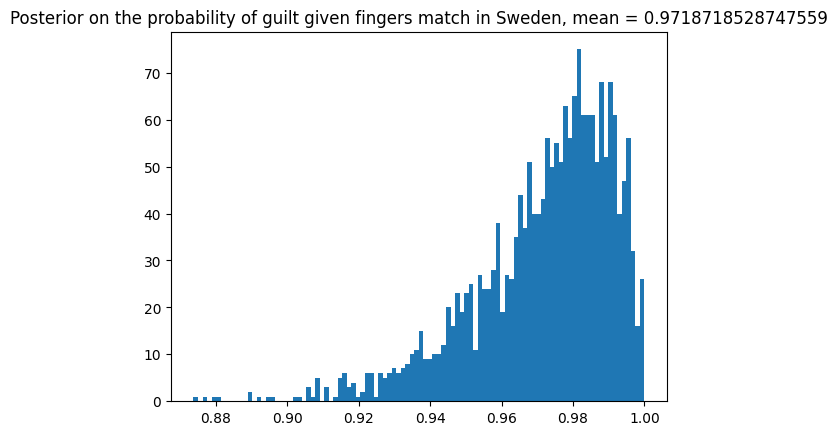

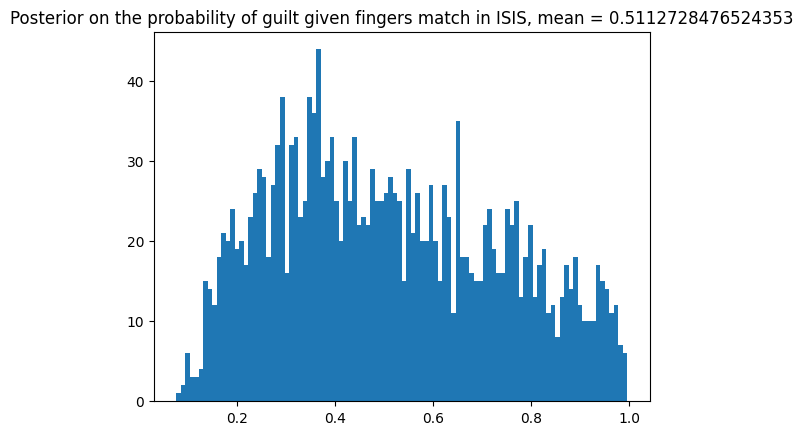

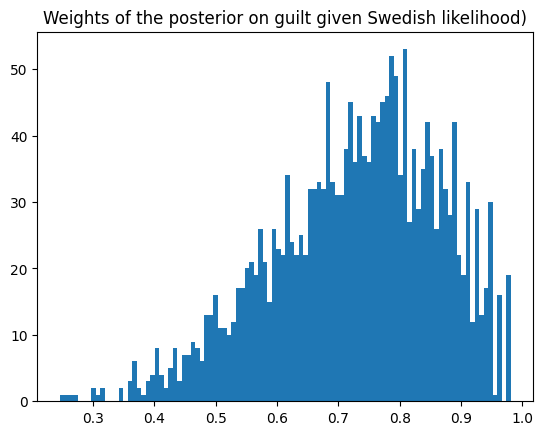

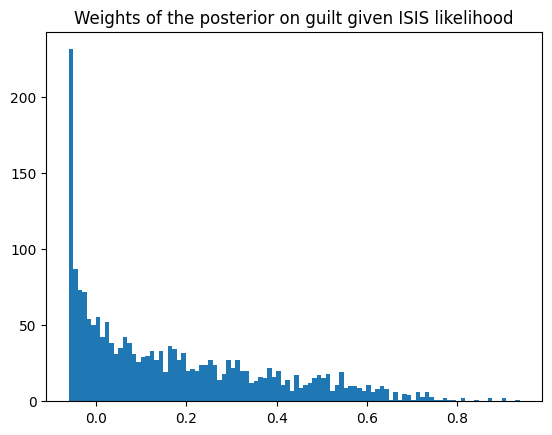

In [28]:
plt.hist(bayesian_samples['sweden_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given Swedish likelihood)")
plt.show()

plt.hist(bayesian_samples['isis_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given ISIS likelihood")
plt.show()

